In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR

In [9]:
plt.rcParams['figure.figsize'] = (10, 7)

In [2]:
housing = pd.read_csv('./data/housing.csv')
housing.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<AxesSubplot:xlabel='housing_median_age', ylabel='Count'>

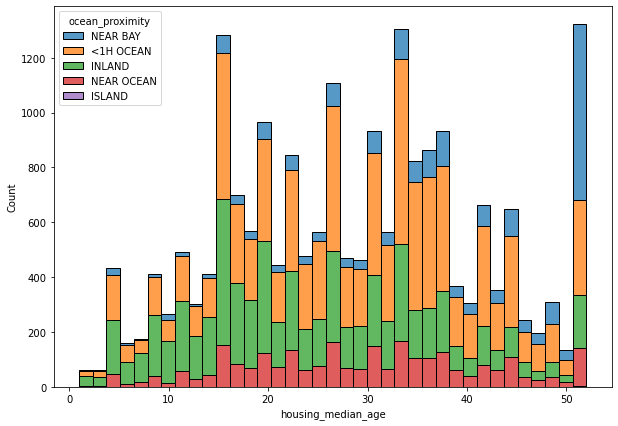

In [11]:
sns.histplot(data=housing, x='housing_median_age', hue='ocean_proximity', multiple='stack')

In [5]:
housing.sample(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

<AxesSubplot:xlabel='median_income', ylabel='Count'>

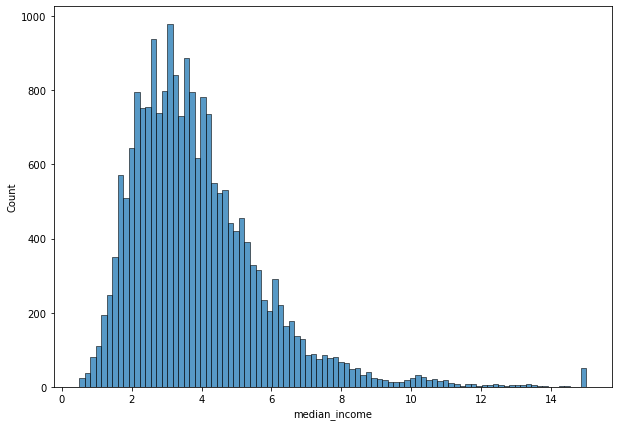

In [4]:
sns.histplot(housing['median_income'])

<AxesSubplot:xlabel='income_cat', ylabel='Count'>

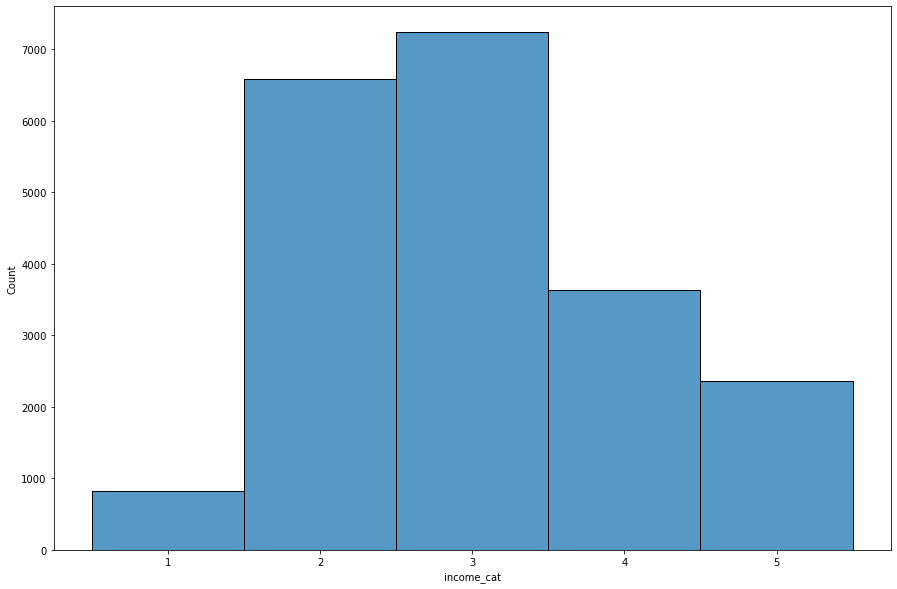

In [60]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               [0, 1.5, 3, 4.5, 6, np.inf],
                               include_lowest=True,
                               labels=[str(i) for i in range(1, 6)])
sns.histplot(housing['income_cat'])

In [61]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
splitted = sss.split(X=housing,
                     y=housing['income_cat'])
for train_index, test_index in splitted:
    housing_train = housing.loc[train_index]
    housing_test = housing.loc[test_index]

housing.drop('income_cat', axis=1, inplace=True)

In [62]:
print(housing_train['income_cat'].value_counts() / len(housing_train))
print(housing_test['income_cat'].value_counts() / len(housing_test))

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [63]:
# zum Vergleich

# random_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#
# for train_index, test_index in random_split.split(X=housing, y=housing['income_cat']):
#     X_train = housing.loc[train_index]
#     X_test = housing.loc[test_index]
#
# print(X_train['income_cat'].value_counts() / len(X_train))
# print(X_test['income_cat'].value_counts() / len(X_test))

In [64]:
X_train = housing_train.drop(['income_cat', 'median_house_value'], axis=1)
y_train = housing_train['median_house_value']

X_test = housing_test.drop(['income_cat', 'median_house_value'], axis=1)
y_test = housing_test['median_house_value']

In [65]:
cat_attributes = ['ocean_proximity']
num_attributes = X_train.columns.drop(cat_attributes)
train_num = X_train[num_attributes]
train_cat = X_train[cat_attributes]

In [66]:
# imputer = SimpleImputer(strategy='median')
# transformed = imputer.fit_transform(train_num)
# train_num = pd.DataFrame(transformed, columns=train_num.columns, index=train_num.index)

In [67]:
# cat_encoder = OneHotEncoder(sparse=False)
# encoded = cat_encoder.fit_transform(train_cat)
# train_cat = pd.DataFrame(encoded, columns=cat_encoder.categories_, index=train_num.index)

In [68]:
room_index = np.where(housing.columns == 'total_rooms')[0][0]
bedroom_index = np.where(housing.columns == 'total_bedrooms')[0][0]
population_index = np.where(housing.columns == 'population')[0][0]
households_index = np.where(housing.columns == 'households')[0][0]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True) -> None:
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, room_index] / X[:, households_index]
        population_per_household = X[:, population_index] / X[:, households_index]
        result = np.c_[X, rooms_per_household, population_per_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_index] / X[:, room_index]
            result = np.c_[result, bedrooms_per_room]
        return result


In [69]:
training = pd.concat([X_train, y_train], axis=1)
correlations_with_y = training.corr().iloc[:-1, -1]
index = (correlations_with_y.apply(np.abs)
         .sort_values(ascending=False)
         [:2]
         .index)
training[index]



median_income  latitude
18697         1.6983     40.58
18848         1.2700     41.41
18321         7.9029     37.45
4861          0.4999     34.02
17945         4.7604     37.33
...              ...       ...
11375         2.3674     33.68
4448          1.7292     34.07
10754         5.6336     33.60
12758         2.4632     38.61
13439         4.1375     34.09

[16512 rows x 2 columns]

In [70]:
class ImportantAttributesFilter(BaseEstimator, TransformerMixin):

    def __init__(self, n_features):
        if n_features < 1:
            raise ValueError()
        self.n_features = n_features
        self.features = None

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        correlations_with_y = data.corr.iloc[:-1, -1]
        self.features = (correlations_with_y.apply(np.abs)
                         .sort_values(ascending=False)
                         [:self.n_features]
                         .index)
        return self

    def transform(self, X, y):
        if self.features is None:
            raise RuntimeError('fit() must be called first')
        return X[self.features]

In [71]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('scaler', StandardScaler())
])

train_num = num_pipeline.fit_transform(train_num)

In [72]:
pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
    ('important', ImportantAttributesFilter, cat_attributes)
], remainder='passthrough')

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [76]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1, 1e-1, 1e-2, 1e-3],
              'gamma': ['scale', 'auto']}
svr = SVR(C=1, gamma='scale', kernel='linear')
svr.fit(X_train, y_train)
#grid = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
#grid.fit(X_train, y_train)

SVR(C=1, kernel='linear')

In [ ]:
grid.best_estimator_

In [ ]:
scores = cross_val_score(grid.best_estimator_,
                         X_train,
                         y_train,
                         cv=10,
                         scoring='neg_mean_squared_error')
scores = np.sqrt(-scores)
scores.mean()

# {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
# Score: 111762

In [ ]:
scores = cross_val_score(svr,
                         X_train,
                         y_train,
                         cv=10,
                         scoring='neg_mean_squared_error')

In [ ]:
scores = np.sqrt(-scores)
scores.mean()

In [75]:
scores = np.sqrt(-scores)
scores.mean()

NameError: name 'grid' is not defined

In [77]:
scores = cross_val_score(svr,
                         X_train,
                         y_train,
                         cv=10,
                         scoring='neg_mean_squared_error')

In [79]:
scores = np.sqrt(-scores)
scores.mean()

110910.22843576653